
## Supervised regression of LC loan data

As my metric (buy rate) is a continuous function, I have turned a simple classification (good vs bad loans) into a regression of return. I find that this would be a better tool for picking loans to invest in, as it forecasts a predicted return, not just if the loan will be paid as agreed. My metric intereacts with the loan interest, prefering higher interest loans that are paid as agreed over lower interest loans, this is not done by simple classification. Successful forecasting of my metric can be the difference between having no defaulting loans, but a 4% return per year (low interest, safe loans) vs having no or few defaulting loans, and 10-15% return per year.


### Getting started

Data exploration and cleaning has been performed using the previous jupyter notebook named "Data Cleaning.ipynb". I exported a clean features and labels pickle using joblib in that notebook. I will import them and graph some preliminary things to start!

In [1]:
import joblib
features=joblib.load('clean_LCfeatures.p')
labels=joblib.load('clean_LClabels.p')
clabels=joblib.load('clean_LCclassifierlabel.p')

In [2]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline


In [3]:
features.head(n=10)

,loan_amnt,emp_title,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med
0,5000.0,None,10.0,RENT,24000.00,credit_card,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,0.0
5,12000.0,UCLA,10.0,OWN,75000.00,debt_consolidation,CA,10.78,0.0,1989-10-01,0.0,12.0,0.0,23336.0,67.1,34.0,0.0
6,9000.0,Va. Dept of Conservation/Recreation,0.5,RENT,30000.00,debt_consolidation,VA,10.08,0.0,2004-04-01,1.0,4.0,0.0,10452.0,91.7,9.0,0.0
7,3000.0,Target,3.0,RENT,15000.00,credit_card,IL,12.56,0.0,2003-07-01,2.0,11.0,0.0,7323.0,43.1,11.0,0.0
9,1000.0,Internal revenue Service,0.5,RENT,28000.00,debt_consolidation,MO,20.31,0.0,2007-09-01,1.0,11.0,0.0,6524.0,81.5,23.0,0.0
13,9200.0,Network Interpreting Service,6.0,RENT,77385.19,debt_consolidation,CA,9.86,0.0,2001-01-01,0.0,8.0,0.0,7314.0,23.1,28.0,0.0
14,21000.0,Osram Sylvania,10.0,RENT,105000.00,debt_consolidation,FL,13.22,0.0,1983-02-01,0.0,7.0,0.0,32135.0,90.3,38.0,0.0
15,10000.0,Value Air,10.0,OWN,50000.00,credit_card,TX,11.18,0.0,1985-07-01,0.0,8.0,0.0,10056.0,82.4,21.0,0.0
16,10000.0,Wells Fargo Bank,5.0,RENT,50000.00,debt_consolidation,CA,16.01,0.0,2003-04-01,0.0,6.0,0.0,17800.0,91.8,17.0,0.0
18,15000.0,Winfield Pathology Consultants,2.0,MORTGAGE,92000.00,credit_card,IL,29.44,0.0,2002-02-01,0.0,8.0,0.0,13707.0,93.9,31.0,0.0


In [4]:
features['earliest_cr_line']=features.earliest_cr_line.dt.year

In [5]:
features.earliest_cr_line.dtype

dtype('int64')

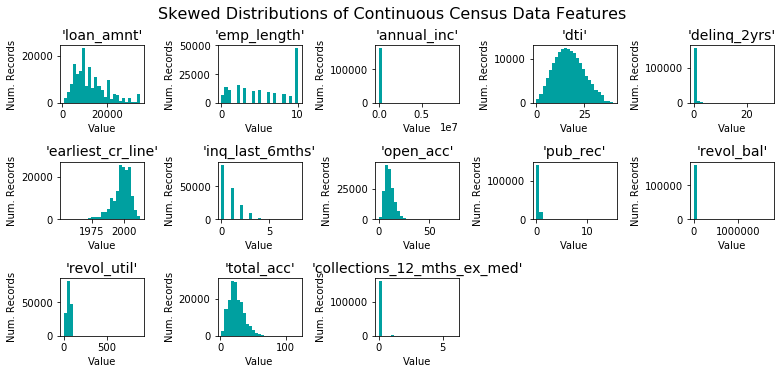

In [6]:
import imp
imp.reload(vs)
vs.distribution(features)

Some weird scaling going on, just to check my sanity, check the max values of a few of the features. these may need to be log scaled just to deal with the large values. Income almost always is going to need log scaling anyway.

In [7]:
valuespread={'annual_inc':max(features.annual_inc),'delinqmax':max(features.delinq_2yrs),
             'openmax':max(features.open_acc), 'pubmax':max(features.pub_rec),
             'revolbalmax':max(features.revol_bal),'revolutilmax':max(features.revol_util),
             'collectmax':max(features.collections_12_mths_ex_med)}
valuespread

{'annual_inc': 8900060.0,
 'collectmax': 6.0,
 'delinqmax': 29.0,
 'openmax': 76.0,
 'pubmax': 15.0,
 'revolbalmax': 1743266.0,
 'revolutilmax': 892.29999999999995}

There are some crazy revolving balances and utilizations. I need to check those quickly. Everything else looks extreme, but within ranges I'd assume could exist.

In [8]:
features.query('revol_bal>1000000.0')

,loan_amnt,emp_title,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med
131832,35000.0,plastic surgery,10.0,MORTGAGE,400000.0,debt_consolidation,FL,33.48,0.0,1984,4.0,28.0,0.0,1743266.0,29.5,59.0,0.0


I guess these are pretty understandable, high paying jobs and income.
Lets check the utilizations - having over 100% seems... not possible.

In [9]:
features.query('revol_util>120')

,loan_amnt,emp_title,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med
68911,7200.0,united states Navy,8.0,MORTGAGE,40000.0,credit_card,CT,30.54,0.0,2001,0.0,4.0,0.0,11533.0,128.1,20.0,0.0
72075,35000.0,"Blachford, Inc.",0.5,MORTGAGE,294000.0,debt_consolidation,GA,7.80,0.0,1982,2.0,6.0,0.0,33066.0,127.6,19.0,0.0
74550,12000.0,Goldman Sachs,3.0,RENT,113000.0,debt_consolidation,UT,12.76,4.0,1990,0.0,5.0,0.0,7357.0,120.2,19.0,0.0
210575,12600.0,"AVP, Senior Leasing Assistant",8.0,MORTGAGE,96011.0,debt_consolidation,MD,11.56,2.0,1981,1.0,9.0,0.0,20033.0,146.1,22.0,0.0
238136,20000.0,Systems Analyst,10.0,MORTGAGE,90000.0,debt_consolidation,CA,7.85,0.0,2000,1.0,5.0,0.0,19616.0,127.4,9.0,0.0
242534,4000.0,Doorline,2.0,RENT,35000.0,debt_consolidation,TN,18.18,0.0,2008,4.0,14.0,0.0,2956.0,123.2,18.0,0.0
294319,10000.0,Superintendent,10.0,OWN,91000.0,debt_consolidation,CA,20.94,0.0,1997,0.0,9.0,0.0,9344.0,150.7,37.0,0.0
294407,3500.0,Budget Analyst,10.0,RENT,45000.0,debt_consolidation,CA,14.67,0.0,1998,0.0,2.0,0.0,2677.0,892.3,9.0,0.0
306159,35000.0,HR Director,10.0,RENT,165800.0,debt_consolidation,MA,7.42,0.0,2005,0.0,5.0,0.0,16521.0,153.0,5.0,0.0
524608,18275.0,Consultant,1.0,OWN,155000.0,debt_consolidation,MA,18.39,0.0,2002,0.0,14.0,1.0,15237.0,141.1,26.0,0.0


Having a utilization over 100% is odd, but having a utilization of almost 900% is crazy! I am going to just remove this one loan - not sure what is going on with this outlier. The others are clearly weird, but there doesn't seem to be an obvious cutoff beyond removing the huge outlier.

In [10]:
features.drop([294407],inplace=True)
labels.drop([294407],inplace=True)
clabels.drop([294407],inplace=True)

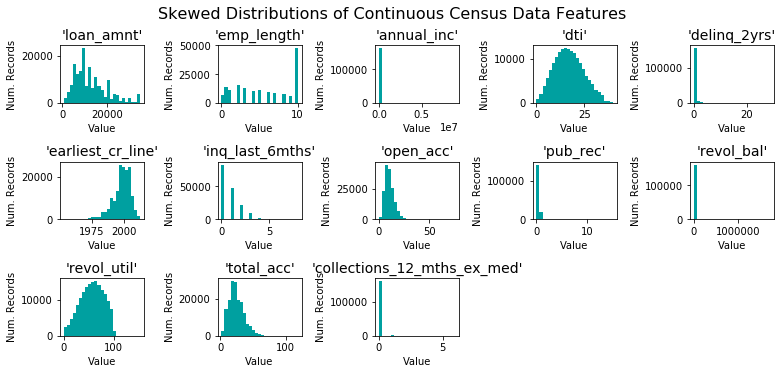

In [11]:
imp.reload(vs)
vs.distribution(features)

Utilization looks much more normal!
Now to log transform the skewed distributions.

## Log transform Skewed data

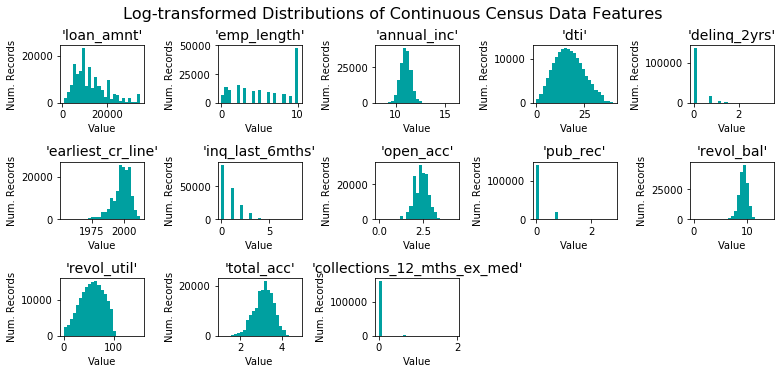

In [12]:
# Log-transform the skewed features

skewed = ['annual_inc','delinq_2yrs','open_acc', 'pub_rec','revol_bal','total_acc', 'collections_12_mths_ex_med']
features_raw=features.copy()
features_raw[skewed] = features[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
imp.reload(vs)
vs.distribution(features_raw, transformed = True)

We see a clear improvement in income, open accounts, and revolving balance. The others are improved but still are dominated by low numbers. That's okay for now. There are extreme outliers but they are important. I am tempted to winsorize, but the values are so heavily weighted toward 0, that the winsorization would affect all values greater than zero.

In [13]:
# import scipy.stats
# winsors=['delinq_2yrs','pub_rec','collections_12_mths_ex_med']
# for feature in winsors:
#     winsor[feature]=scipy.stats.mstats.winsorize(features[feature], limits=0.01,axis=1)

## Normalization

Now we normalize, by scaling by the max and min values.

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['loan_amnt','emp_length', 'annual_inc','dti','delinq_2yrs','earliest_cr_line','inq_last_6mths','open_acc', 'pub_rec','revol_bal','revol_util','total_acc', 'collections_12_mths_ex_med']
features_raw[numerical] = scaler.fit_transform(features_raw[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 10))


,loan_amnt,emp_title,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med
0,0.125364,None,1.00,RENT,0.230473,credit_card,AZ,0.691423,0.0,0.534483,0.125,0.319143,0.0,0.662532,0.547059,0.327121,0.0
5,0.329446,UCLA,1.00,OWN,0.378689,debt_consolidation,CA,0.269567,0.0,0.603448,0.000,0.590484,0.0,0.699854,0.438562,0.667499,0.0
6,0.241983,Va. Dept of Conservation/Recreation,0.05,RENT,0.259499,debt_consolidation,VA,0.252063,0.0,0.862069,0.125,0.370513,0.0,0.643968,0.599346,0.327121,0.0
7,0.067055,Target,0.30,RENT,0.169337,credit_card,IL,0.314079,0.0,0.844828,0.250,0.572058,0.0,0.619215,0.281699,0.376658,0.0
9,0.008746,Internal revenue Service,0.05,RENT,0.250524,debt_consolidation,MO,0.507877,0.0,0.913793,0.125,0.572058,0.0,0.611177,0.532680,0.564987,0.0
13,0.247813,Network Interpreting Service,0.60,RENT,0.382761,debt_consolidation,CA,0.246562,0.0,0.810345,0.000,0.505829,0.0,0.619130,0.150980,0.616404,0.0
14,0.591837,Osram Sylvania,1.00,RENT,0.422457,debt_consolidation,FL,0.330583,0.0,0.500000,0.000,0.478714,0.0,0.722116,0.590196,0.696900,0.0
15,0.271137,Value Air,1.00,OWN,0.325946,credit_card,TX,0.279570,0.0,0.534483,0.000,0.505829,0.0,0.641281,0.538562,0.541346,0.0
16,0.271137,Wells Fargo Bank,0.50,RENT,0.325946,debt_consolidation,CA,0.400350,0.0,0.844828,0.000,0.447974,0.0,0.681012,0.600000,0.486824,0.0
18,0.416910,Winfield Pathology Consultants,0.20,MORTGAGE,0.405264,credit_card,IL,0.736184,0.0,0.827586,0.000,0.505829,0.0,0.662832,0.613725,0.643151,0.0


## One Hot Encoding

Up to this point, I have only dealt with the "continuous" numerical features, or features where the values have some relation. for example, higher income can be directly compared to lower income. Now I want to deal with discrete features, where values are independent. One example is the address state. Although we all might have a specific way to rank the states, there is no "correct" relationship between any two possible states - they are discrete and independent. These will be one-hot encoded!

Of note is the employment title - this is put in by the person applying to the loan and can be pretty much anything. This will certainly cause an explosion in feature space. I think, at this point, I will just remove that from the feature space instead of encode it.



In [15]:
features_raw

,loan_amnt,emp_title,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med
0,0.125364,None,1.00,RENT,0.230473,credit_card,AZ,0.691423,0.000000,0.534483,0.125,0.319143,0.000000,0.662532,0.547059,0.327121,0.000000
5,0.329446,UCLA,1.00,OWN,0.378689,debt_consolidation,CA,0.269567,0.000000,0.603448,0.000,0.590484,0.000000,0.699854,0.438562,0.667499,0.000000
6,0.241983,Va. Dept of Conservation/Recreation,0.05,RENT,0.259499,debt_consolidation,VA,0.252063,0.000000,0.862069,0.125,0.370513,0.000000,0.643968,0.599346,0.327121,0.000000
7,0.067055,Target,0.30,RENT,0.169337,credit_card,IL,0.314079,0.000000,0.844828,0.250,0.572058,0.000000,0.619215,0.281699,0.376658,0.000000
9,0.008746,Internal revenue Service,0.05,RENT,0.250524,debt_consolidation,MO,0.507877,0.000000,0.913793,0.125,0.572058,0.000000,0.611177,0.532680,0.564987,0.000000
13,0.247813,Network Interpreting Service,0.60,RENT,0.382761,debt_consolidation,CA,0.246562,0.000000,0.810345,0.000,0.505829,0.000000,0.619130,0.150980,0.616404,0.000000
14,0.591837,Osram Sylvania,1.00,RENT,0.422457,debt_consolidation,FL,0.330583,0.000000,0.500000,0.000,0.478714,0.000000,0.722116,0.590196,0.696900,0.000000
15,0.271137,Value Air,1.00,OWN,0.325946,credit_card,TX,0.279570,0.000000,0.534483,0.000,0.505829,0.000000,0.641281,0.538562,0.541346,0.000000
16,0.271137,Wells Fargo Bank,0.50,RENT,0.325946,debt_consolidation,CA,0.400350,0.000000,0.844828,0.000,0.447974,0.000000,0.681012,0.600000,0.486824,0.000000
18,0.416910,Winfield Pathology Consultants,0.20,MORTGAGE,0.405264,credit_card,IL,0.736184,0.000000,0.827586,0.000,0.505829,0.000000,0.662832,0.613725,0.643151,0.000000


In [16]:
features_raw=features_raw.drop(['emp_title','addr_state'],axis=1)

In [17]:
features_raw.dtypes

loan_amnt                     float64
emp_length                    float64
home_ownership                 object
annual_inc                    float64
purpose                        object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line              float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
revol_util                    float64
total_acc                     float64
collections_12_mths_ex_med    float64
dtype: object

In [18]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
feat = pd.get_dummies(features_raw)


#print(income.head(n=10))
# Print the number of features after one-hot encoding
encoded = list(feat.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print (encoded)

18 total features after one-hot encoding.
['loan_amnt', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'purpose_credit_card', 'purpose_debt_consolidation']


Great! There are the original continuous features, and now a feature for all types of home ownership, purposes for the loan, and different address states!

## Shuffle and split data

Specifically, I believe that this data is ordered by the origination date, so it is important to shuffle the data. Luckily this happens anyway with train_test_split.

In [19]:
# Import train_test_split
from sklearn.model_selection import train_test_split #sklearn 0.18.1 and up
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feat, labels, test_size = 0.2, random_state = 1)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 130367 samples.
Testing set has 32592 samples.


## Testing different models

For almost all supervised learning, a version of Decision trees is necessary to test, if only for it's extreme intuitiveness. At the very least, it may be used to shrink the feature space and improve speed for other algorithms. I will use Gradient Boosting regression for this. Secondly, I want to test a kernel based non-linear regression, and I will use KNN for this. Finally I want to test a high order polynomial regression.

### defining model tester

In [20]:
from sklearn.metrics import r2_score, mean_squared_error
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = clf.fit(X_train.sample(n=sample_size,random_state=1),y_train.sample(n=sample_size,random_state=1)) #df.sample(frac=percent) maybe too?
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = clf.predict(X_test)
    predictions_train = clf.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute mean square error on the first 300 training samples
    results['mse_train'] = mean_squared_error(y_train[:300],predictions_train)
        
    # Compute mean square error on test set
    results['mse_test'] = mean_squared_error(y_test,predictions_test)
    
    # Compute R^2 on the the first 300 training samples
    results['R2_train'] = r2_score(y_train[:300],predictions_train)
        
    # Compute R^2 on the test set
    results['R2_test'] = r2_score(y_test,predictions_test)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

Pipeline trained on 1304 samples.
Pipeline trained on 13037 samples.
Pipeline trained on 130367 samples.
GradientBoostingRegressor trained on 1304 samples.
GradientBoostingRegressor trained on 13037 samples.
GradientBoostingRegressor trained on 130367 samples.
Ridge trained on 1304 samples.
Ridge trained on 13037 samples.
Ridge trained on 130367 samples.


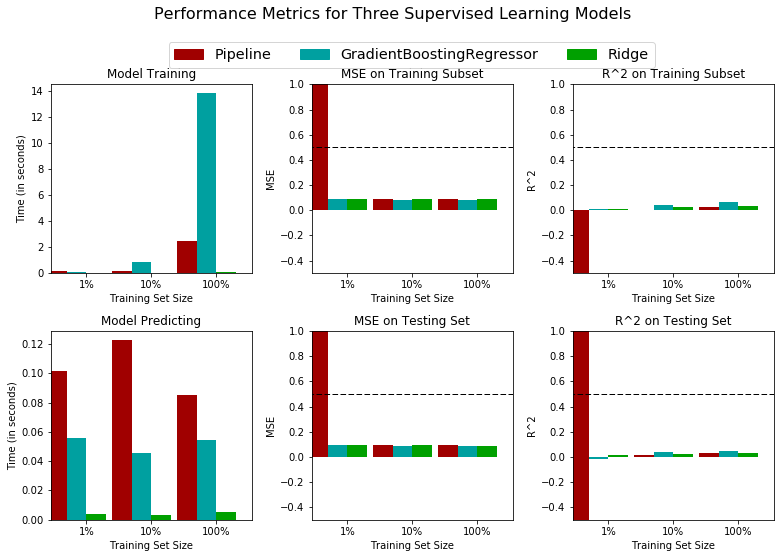

In [21]:
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# Initialize models

clf_A = make_pipeline(PolynomialFeatures(2,interaction_only=True),LinearRegression())
clf_B = GradientBoostingRegressor(random_state=2)
clf_C = Ridge()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = len(y_train.sample(frac=.01))
samples_10 = len(y_train.sample(frac=.1))
samples_100 = len(y_train.sample(frac=1))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]: #clf_A, 
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
#         print(results[clf])

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results,.5,.5)

### Checking the polynomial regression

These values look huge, I need to check why they are breaking the graphs

In [22]:
results

{'GradientBoostingRegressor': {0: {'R2_test': -0.017870972164328869,
   'R2_train': 0.010755331570289961,
   'mse_test': 0.090052558801698684,
   'mse_train': 0.092208900986106915,
   'pred_time': 0.05549001693725586,
   'train_time': 0.12314391136169434},
  1: {'R2_test': 0.036777618549970637,
   'R2_train': 0.039383543991014625,
   'mse_test': 0.085217716701559781,
   'mse_train': 0.089540424633636789,
   'pred_time': 0.04588580131530762,
   'train_time': 0.8976330757141113},
  2: {'R2_test': 0.047226099129669796,
   'R2_train': 0.067366979025568097,
   'mse_test': 0.084293324084496468,
   'mse_train': 0.086932048897381153,
   'pred_time': 0.05476188659667969,
   'train_time': 13.808783054351807}},
 'Pipeline': {0: {'R2_test': -3.5921909190462054e+18,
   'R2_train': -56765069967627.102,
   'mse_test': 3.1780647332588608e+17,
   'mse_train': 5291152819072.6514,
   'pred_time': 0.10138607025146484,
   'train_time': 0.14394807815551758},
  1: {'R2_test': 0.017439827412664477,
   'R2_tra

## Regression Postmortem

Woof, terrible bias, almost no structure is described by these models. I'm actually not sure what to make of such extreme values, but negative R^2 are bad, and large MSE is bad. Likely, they are too simple. I'd like to try and overfit, before I move towards a more modest approach, such as classification. If I can tune a decision tree from overfitting towards something useful, maybe the metric and this regression still have hope.

### Attempting to overfit.

For this I will use a standard decision tree, and attempt to overfit with hopes for Post-pruning 

In [23]:
from sklearn.tree import DecisionTreeRegressor
results2={}
clf_D = DecisionTreeRegressor(random_state=1)
clf_D.fit(X_train,y_train)
predictions_test = clf_D.predict(X_test)
predictions_train = clf_D.predict(X_train[:3000])
end = time() # Get end time

# Calculate the total prediction time

# Compute mean square error on the first 300 training samples
results2['mse_train'] = mean_squared_error(y_train[:3000],predictions_train)

# Compute mean square error on test set
results2['mse_test'] = mean_squared_error(y_test,predictions_test)

# Compute R^2 on the the first 300 training samples
results2['R2_train'] = r2_score(y_train[:3000],predictions_train)

# Compute R^2 on the test set
results2['R2_test'] = r2_score(y_test,predictions_test)

results2

{'R2_test': -0.99260421344961225,
 'R2_train': 0.99999998936712031,
 'mse_test': 0.17628865839315286,
 'mse_train': 9.3262424912010249e-10}

## Overfitting with Decision Trees - Success?

Looks like we have classic high variance now (great training scores, terrible test scores)! This makes me more confident that the metric is tenable. 

## Gridsearch Decision Tree model tuning

Now I'll try to tune the decision tree using gridsearch CV.

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# Initialize the classifier
clf = DecisionTreeRegressor(random_state=2)

# Create the parameters list you wish to tune
parameters = {'max_depth':(4,6,20,None),'min_samples_split':(2,50),'min_samples_leaf':(1,101)} #',,

# Make an R2_score scoring object
scorer = make_scorer(r2_score)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf,parameters,scoring=scorer,n_jobs=-1)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)
# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("MSE score on testing data: {:.4f}".format(mean_squared_error(y_test, predictions)))
print ("R2-score on testing data: {:.4f}".format(r2_score(y_test, predictions)))
print ("\nOptimized Model\n------")
print ("Final MSE score on the testing data: {:.4f}".format(mean_squared_error(y_test, best_predictions)))
print ("Final R2-score on the testing data: {:.4f}".format(r2_score(y_test, best_predictions)))


Unoptimized model
------
MSE score on testing data: 0.1759
R2-score on testing data: -0.9880

Optimized Model
------
Final MSE score on the testing data: 0.0858
Final R2-score on the testing data: 0.0301


In [25]:
best_clf

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=101, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=2,
           splitter='best')

In [26]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer
# # Initialize the classifier
# clf = GradientBoostingRegressor(random_state=2)

# # Create the parameters list you wish to tune
# parameters = {'learning_rate':(0.01,0.1), 'max_depth':(3,6)} 

# # Make an R2_score scoring object
# scorer = make_scorer(r2_score)

# # TODO: Perform grid search on the classifier using 'scorer' as the scoring method
# grid_obj = GridSearchCV(clf,parameters,scoring=scorer,n_jobs=-1)

# # TODO: Fit the grid search object to the training data and find the optimal parameters
# grid_fit = grid_obj.fit(X_train,y_train)

# # Get the estimator
# best_clf = grid_fit.best_estimator_

# # Make predictions using the unoptimized and model
# predictions = (clf.fit(X_train, y_train)).predict(X_test)
# best_predictions = best_clf.predict(X_test)
# # Report the before-and-afterscores
# print ("Unoptimized model\n------")
# print ("MSE score on testing data: {:.4f}".format(mean_squared_error(y_test, predictions)))
# print ("R2-score on testing data: {:.4f}".format(r2_score(y_test, predictions)))
# print ("\nOptimized Model\n------")
# print ("Final MSE score on the testing data: {:.4f}".format(mean_squared_error(y_test, best_predictions)))
# print ("Final R2-score on the testing data: {:.4f}".format(r2_score(y_test, best_predictions)))

In [27]:
best_clf

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=101, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=2,
           splitter='best')

Interestingly, the best boosted regressor is the "stock" one. It is pretty poor. I think it is time to try classification instead of regression

# Classification of Loan Data

In this case, we take the classification data, which takes "current" and "fully paid" loans and groups, them, and groups all other delinquent loans together. First, we must get a new test split, and then we will get a baseline naive predictor.

In [28]:
# Import train_test_split
from sklearn.model_selection import train_test_split #sklearn 0.18.1 and up
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feat, clabels, test_size = 0.2, random_state = 1)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 130367 samples.
Testing set has 32592 samples.


## Naive Predictor

Here we make a naive predictor, that simply guesses every loan is "good" (or bad, if more loans are bad than good). We need to beat these scores in order to really say that our model is doing better than this in order to say it is meaningful. For classification I will test accuracy, $f_{0.5}$ score, ROC AUC, and cohen's kappa to determine the quality of the model with this highly imbalanced dataset. I use $f_{0.5}$ specifically instead of other beta values because I care most about being precise! I'd rather misclassify a few good loans as bad than have bad loans slip through. Missing a good loan carries much less risk than funding a bad loan. I could look at tuning the classification by implementing a cost of misclassification...
ROC AUC takes into consideration true positive rates and false positive rates, and can deal with unbalanced data.
Cohen's kappa is specifically for unbalanced data, and describes the agreement 

In [29]:

from sklearn.metrics import accuracy_score,fbeta_score, roc_auc_score, cohen_kappa_score, precision_score
allones=np.ones(len(clabels))
acc=accuracy_score(clabels,allones)
fbeta=fbeta_score(clabels,allones,beta=.5)
auc=roc_auc_score(clabels,allones)
cohen=cohen_kappa_score(clabels,allones)
prec=precision_score(clabels,allones)

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}, ROC AUC: {:.4f}, Cohen's k: {:.4f}, precision: {:.4f}]".format(acc, fbeta,auc,cohen,prec))


Naive Predictor: [Accuracy score: 0.7983, F-score: 0.8318, ROC AUC: 0.5000, Cohen's k: 0.0000, precision: 0.7983]


Wow! accuracy and F-score are pretty high. likely, this is because there is an order of magnitude more fully paid loans than others. This can be seen in the data cleaning notebook! Interestingly, ROC AUC and Cohen's k show how poor a naive classifier should be. I'll use those to judge my models.

## Testing Classifiers

I am choosing three classifiers: Decision trees, as it is obligatory to try them on any classification - they get 80% of the way there 80% of the time. SVM, as the margin is a desirable trait when "current" loans are ambiguous and we'd like a large berth for the classification. and finally, KNN, as it is one of the simpliest models (a lazy learner) and I love to see simplicity win out.

In [30]:
from sklearn.metrics import fbeta_score, roc_auc_score, cohen_kappa_score
def train_predictclass(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    resultsclass = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = clf.fit(X_train.sample(n=sample_size,random_state=1),y_train.sample(n=sample_size,random_state=1)) #df.sample(frac=percent) maybe too?
    end = time() # Get end time
    
    # Calculate the training time
    resultsclass['train_time'] = end-start
        
    # Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = clf.predict(X_test)
    predictions_train = clf.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    resultsclass['pred_time'] = end-start
            
    # Compute accuracy on the first 300 training samples
    resultsclass['ROC_AUC_train'] = roc_auc_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set
    resultsclass['ROC_AUC_test'] = roc_auc_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples
    resultsclass['precision_train'] = precision_score(y_train[:300],predictions_train)
        
    # Compute F-score on the test set
    resultsclass['precision_test'] = precision_score(y_test,predictions_test)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return resultsclass

In [31]:
# Initialize models
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=5)
clf_C = RandomForestClassifier(n_estimators=50)


# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = len(y_train.sample(frac=.01))
samples_10 = len(y_train.sample(frac=.1))
samples_100 = len(y_train.sample(frac=1))

# Collect results on the learners
resultsclass = {}
for clf in [clf_A, clf_B, clf_C]: 
    clf_name = clf.__class__.__name__
    resultsclass[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        resultsclass[clf_name][i] = \
        train_predictclass(clf, samples, X_train, y_train, X_test, y_test)
#         print(results[clf])



GaussianNB trained on 1304 samples.
GaussianNB trained on 13037 samples.
GaussianNB trained on 130367 samples.
DecisionTreeClassifier trained on 1304 samples.
DecisionTreeClassifier trained on 13037 samples.
DecisionTreeClassifier trained on 130367 samples.
RandomForestClassifier trained on 1304 samples.
RandomForestClassifier trained on 13037 samples.
RandomForestClassifier trained on 130367 samples.


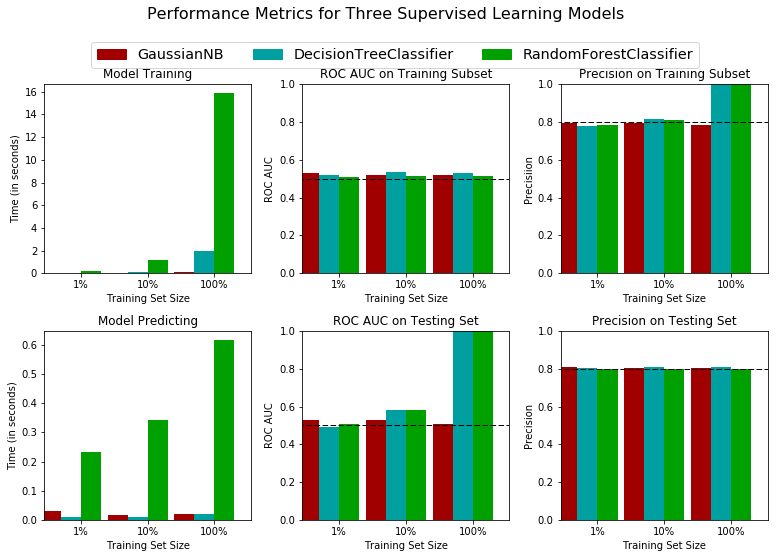

In [32]:
# Run metrics visualization for the three supervised learning models chosen
imp.reload(vs)
vs.classevaluate(resultsclass,auc,prec)

## Results

This is promising! The decision tree unsurprisingly shows the best scores on the testing set. I'll try to optimize decision trees next! I will attempt to prune the tree a bit with grid search.

In [39]:

# Initialize the classifier
clf = DecisionTreeClassifier(random_state=3)

# Create the parameters list you wish to tune
parameters = {'max_depth':(20,50, None),'max_leaf_nodes':(100,300,None)}

# Make an R2_score scoring object
scorer = make_scorer(precision_score)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf,parameters,scoring=scorer,n_jobs=-1)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)



In [40]:
# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("ROC AUC score on testing data: {:.4f}".format(roc_auc_score(y_test, predictions)))
print ("Precision on testing data: {:.4f}".format(precision_score(y_test, predictions)))
print ("\nOptimized Model\n------")
print ("Final ROC AUC score on the testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
print ("Final Precision on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))


Unoptimized model
------
ROC AUC score on testing data: 0.5294
Precision on testing data: 0.8078

Optimized Model
------
Final ROC AUC score on the testing data: 0.5294
Final Precision on the testing data: 0.8078


Interestingly, this doesn't really improve the precision, there may not be enough bad loan data to give the model something to hang on to, and potentially, it could be that we just don't have the data collected that would be more predictive. Because it is crazy simple, and it actually performs better at reducing false positives than others, at least with this training/test set. It is worth noting that the 0.0095% increase in accuracy over the naive classifier is very small but better than nothing.

In [41]:
import joblib
joblib.dump(clf, 'decisiontree.p')

['decisiontree.p']